In [12]:
import glob
import numpy as np
import pandas as pd
import scipy
from nilearn import plotting


In [ ]:
# first load all seed based files
files_ses1 = glob.glob('/home/or/kpe_conn/trauma_seed_amg_right_sub-*_ses-1_z.nii.gz')
files_ses2 = glob.glob('/home/or/kpe_conn/trauma_seed_amg_right_sub-*_ses-2_z.nii.gz')
print(files_ses1)
#len(files)

In [ ]:
# reading the files back
from nilearn.input_data import NiftiMasker
# here I use a masked image so all will have same size
nifti_masker = NiftiMasker(
    mask_img= '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
    smoothing_fwhm=5,
    memory='nilearn_cache', memory_level=1)  # cache options
fmri_AmgR_masked_ses1 = nifti_masker.fit_transform(files_ses1)
fmri_AmgR_masked_ses2 = nifti_masker.fit_transform(files_ses2)


In [ ]:
from nilearn import input_data
brain_masker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        low_pass=0.1, high_pass=0.01, t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
brain_masker.fit(files_ses2)

In [ ]:
deltaCor = fmri_AmgR_masked_ses2 - fmri_AmgR_masked_ses1
print (f'Shape is: {deltaCor.shape}')

# run paired t-test 
testDelta = scipy.stats.ttest_rel(fmri_AmgR_masked_ses1, fmri_AmgR_masked_ses2) 
np.sum(testDelta[1]<0.005)

In [ ]:
# results before thresholding
%matplotlib inline
# mean across subjects
mean_zcor_Delta = np.mean(deltaCor,0)
mean_zcor_Delta.shape

In [ ]:
# before using that we need to run and fit brain masker at least on one subject
amygdala_coords = [(31,4,-22)]
mean_zcor_img_delta = brain_masker.inverse_transform(mean_zcor_Delta.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img_delta,
                                     threshold=0.1, vmax=1,
                                     cut_coords=amygdala_coords[0],
                                     title="Seed-to-voxel correlation (Right Hippo) 2nd - 1st session", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# treshold
FWE_thr = 0.05/26503 #len(mean_zcor_Delta)
len(mean_zcor_Delta)/10

In [ ]:
corr_matDelta_thr = np.array(mean_zcor_Delta)
# now I can treshold the mean matrix
corr_matDelta_thr[testDelta[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZeroDelta = np.count_nonzero(corr_matDelta_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZeroDelta}')
# transofrm it back to nifti
thr_nifti_delta = brain_masker.inverse_transform(corr_matDelta_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti_delta,
                                     vmax=1,
                                     threshold = 0.1,
                                     title="Seed-to-voxel correlation 2nd - 1st (Right Amg)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# now lets try FDR
from statsmodels.stats import multitest
# we need to reshape the test p-values array to create 1D array
#b = np.reshape(np.array(testDelta[1]), -1)
fdr_mat = multitest.multipletests(testDelta[1], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#fdr_mat = multitest.fdrcorrection(testDelta[1], alpha=0.7, method='indep', is_sorted=False)

np.sum(fdr_mat[1]<0.01)
#fdr_mat[1]

In [ ]:
tested_var = [1] * 21
tested_var = np.array(tested_var).reshape(-1,1)
tested_var

In [ ]:
from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(
    smoothing_fwhm=0,
    memory='nilearn_cache', memory_level=1)  # cache options
fmri_masked_ses1 = nifti_masker.fit_transform(files_ses1)
fmri_masked_ses2 = nifti_masker.fit_transform(files_ses2)

In [ ]:
from nilearn import mass_univariate
neg_log_pvals_permuted_ols, _, _ = mass_univariate.permuted_ols(tested_var, fmri_masked, confounding_vars=None, model_intercept=True, 
                                     n_perm=50, two_sided_test=True, random_state=None, n_jobs=1, verbose=5)

In [ ]:
neg_log_pvals_permuted_ols_unmasked = nifti_masker.inverse_transform(
    np.ravel(neg_log_pvals_permuted_ols))

In [ ]:
from nilearn.plotting import plot_stat_map, show
import matplotlib.pyplot as plt
# Various plotting parameters
z_slice = 12  # plotted slice

threshold = - np.log10(0.1)  # 10% corrected
vmax = np.max(neg_log_pvals_permuted_ols)

# Plot permuted OLS p-values
fig = plt.figure() #(figsize=(5, 7), facecolor='k')

display = plot_stat_map(neg_log_pvals_permuted_ols_unmasked,
                        threshold=threshold,
                        display_mode='z', cut_coords=[z_slice],
                        vmax=vmax, black_bg=True)

n_detections = (neg_log_pvals_permuted_ols_unmasked.get_data()
                > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.2)

show()

In [ ]:
from nilearn import mass_univariate
neg_log_pvals_permuted_ols2, _, _ = mass_univariate.permuted_ols(tested_var, fmri_masked2, confounding_vars=None, model_intercept=True, 
                                     n_perm=50, two_sided_test=True, random_state=None, n_jobs=1, verbose=5)

In [ ]:
neg_log_pvals_permuted_ols_unmasked2 = nifti_masker.inverse_transform(
    np.ravel(neg_log_pvals_permuted_ols2))

In [ ]:
z_slice = 12  # plotted slice

threshold = - np.log10(0.1)  # 10% corrected
vmax = np.max(neg_log_pvals_permuted_ols2)

# Plot permuted OLS p-values
fig = plt.figure() #(figsize=(5, 7), facecolor='k')

display = plot_stat_map(neg_log_pvals_permuted_ols_unmasked2,
                        threshold=threshold,
                        display_mode='z', cut_coords=[z_slice],
                        vmax=vmax, black_bg=True)

n_detections = (neg_log_pvals_permuted_ols_unmasked2.get_data()
                > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.2)

show()

In [ ]:
from nilearn import input_data
brain_masker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        low_pass=0.1, high_pass=0.01, t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
brain_masker.fit(files_ses2)

In [ ]:
import scipy
import numpy as np
amygdala_coords = [(-26, 2, -18)]#, (31,4,-22)]
# start with simple t test and tresholding
test = scipy.stats.ttest_1samp(fmri_masked,0,0)
%matplotlib inline
# mean across subjects
mean_zcor = np.mean(fmri_masked,0)
# before using that we need to run and fit brain masker at least on one subject

mean_zcor_img = brain_masker.inverse_transform(mean_zcor.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img,
                                     threshold=0.2, vmax=1,
                                     
                                     title="Seed-to-voxel correlation (Left Amg seed)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# treshold
#FWE
FWE_thr = 0.05/len(mean_zcor)
# create new matrix for correction
corr_mat_thr = np.array(mean_zcor)
# now I can treshold the mean matrix
corr_mat_thr[test[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZero = np.count_nonzero(corr_mat_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZero}')
# transofrm it back to nifti
thr_nifti = brain_masker.inverse_transform(corr_mat_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti,
                                      vmax=1,
                                     threshold = 0.2,
                                     title="Seed-to-voxel correlation (Left Amg seed)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# now we should compare the two sessions
test = scipy.stats.ttest_1samp(fmri_masked_ses2,0,0)
%matplotlib inline
# mean across subjects
mean_zcor = np.mean(fmri_masked_ses2,0)
# before using that we need to run and fit brain masker at least on one subject

mean_zcor_img = brain_masker.inverse_transform(mean_zcor.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img,
                                     threshold=0.2, vmax=1,
                                     
                                     title="Seed-to-voxel correlation (Left Amg seed)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# Hippocampus
files_ses1_h = glob.glob('/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-*_ses-1_z.nii.gz')
files_ses2_h = glob.glob('/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-*_ses-2_z.nii.gz')

In [ ]:
from nilearn.input_data import NiftiMasker
# here I use a masked image so all will have same size
nifti_masker = NiftiMasker(
    mask_img= '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
    smoothing_fwhm=5,
    memory='nilearn_cache', memory_level=1)  # cache options
fmri_Hipp_masked_ses1 = nifti_masker.fit_transform(files_ses1_h)
fmri_Hipp_masked_ses2 = nifti_masker.fit_transform(files_ses2_h)


In [ ]:
from nilearn import input_data
brain_masker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        low_pass=0.1, high_pass=0.01, t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
brain_masker.fit(files_ses1_h)

In [ ]:
import scipy
import numpy as np
hippocampus_coors = [(24,-28,-10)]
# start with simple t test and tresholding
test = scipy.stats.ttest_1samp(fmri_Hipp_masked_ses1,0,0)
%matplotlib inline
# mean across subjects
mean_zcor = np.mean(fmri_Hipp_masked_ses1,0)
# before using that we need to run and fit brain masker at least on one subject

mean_zcor_img = brain_masker.inverse_transform(mean_zcor.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img,
                                     threshold=0.2, vmax=1,
                                     
                                     title="Seed-to-voxel correlation (Right Hippo)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [ ]:
# treshold
#FWE
FWE_thr = 0.05/len(mean_zcor)
# create new matrix for correction
corr_mat_thr = np.array(mean_zcor)
# now I can treshold the mean matrix
corr_mat_thr[test[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZero = np.count_nonzero(corr_mat_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZero}')
# transofrm it back to nifti
thr_nifti = brain_masker.inverse_transform(corr_mat_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti,
                                      vmax=1,
                                     threshold = 0.2,
                                     title="Seed-to-voxel correlation (Right Hippocampus)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [ ]:
# run the same for session 2
brain_masker.fit(files_ses2_h)

test = scipy.stats.ttest_1samp(fmri_Hipp_masked_ses2,0,0)
%matplotlib inline
# mean across subjects
mean_zcor = np.mean(fmri_Hipp_masked_ses2,0)
# before using that we need to run and fit brain masker at least on one subject
mean_zcor.shape

In [ ]:
mean_zcor_img = brain_masker.inverse_transform(mean_zcor.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img,
                                     threshold=0.2, vmax=1,
                                     
                                     title="Seed-to-voxel correlation (Right Hippo) 2nd session", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [ ]:
corr_mat_thr = np.array(mean_zcor)
# now I can treshold the mean matrix
corr_mat_thr[test[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZero = np.count_nonzero(corr_mat_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZero}')
# transofrm it back to nifti
thr_nifti = brain_masker.inverse_transform(corr_mat_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti,
                                      vmax=1,
                                     threshold = 0.02,
                                     title="Seed-to-voxel correlation (Right Hippocampus)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [ ]:
deltaCor = fmri_Hipp_masked_ses2 - fmri_Hipp_masked_ses1
print (f'Shape is: {deltaCor.shape}')

# run paired t-test 
testDelta = scipy.stats.ttest_rel(fmri_Hipp_masked_ses1, fmri_Hipp_masked_ses2) 
np.sum(testDelta[1]<0.05)
#testDelta


In [ ]:
%matplotlib inline
# mean across subjects
mean_zcor_Delta = np.mean(deltaCor,0)
# before using that we need to run and fit brain masker at least on one subject

mean_zcor_img_delta = brain_masker.inverse_transform(mean_zcor_Delta.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img_delta,
                                     threshold=0.1, vmax=1,
                                     
                                     title="Seed-to-voxel correlation (Right Hippo) 2nd - 1st session", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [ ]:
# treshold
FWE_thr = 0.05/len(mean_zcor_Delta)
corr_matDelta_thr = np.array(mean_zcor_Delta)
# now I can treshold the mean matrix
corr_matDelta_thr[testDelta[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZeroDelta = np.count_nonzero(corr_matDelta_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZeroDelta}')
# transofrm it back to nifti
thr_nifti_delta = brain_masker.inverse_transform(corr_matDelta_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti_delta,
                                     vmax=1,
                                     threshold = 0.1,
                                     title="Seed-to-voxel correlation 2nd - 1st (Right Hippocampus)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [ ]:
testDelta[1].shape
#b.shape

In [ ]:
# now lets try FDR
from statsmodels.stats import multitest
# we need to reshape the test p-values array to create 1D array
#b = np.reshape(np.array(testDelta[1]), -1)
#fdr_mat = multitest.multipletests(testDelta[1], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
fdr_mat = multitest.fdrcorrection(testDelta[1], alpha=0.7, method='indep', is_sorted=False)

fdr_mat[1]
#fdr_mat[1]

In [ ]:
corr_mat_thrFDR = np.array(mean_zcor_Delta)
corr_mat_thrFDR = np.reshape(corr_mat_thrFDR, -1)
print(f'The number of voxels crossed FDR is {sum(fdr_mat[0])}')
corr_mat_thrFDR[fdr_mat[0]==False] = 0
nifti_fdr_thr = brain_masker.inverse_transform(corr_mat_thrFDR.T)

In [ ]:
display = plotting.plot_stat_map(nifti_fdr_thr,
                                     vmax=1,
                                     threshold = 0.2,
                                     title="Seed-to-voxel correlation 2nd - 1st (Right Hippocampus)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

In [33]:
# using fslMaths to create differences images (between session 1 and two etc.)
# load those ones
diff_images = glob.glob('/home/or/kpe_conn/fsl/maths/hippRight_ses2-1_*.nii.gz')

In [35]:
from nilearn.input_data import NiftiMasker
# here I use a masked image so all will have same size
nifti_masker = NiftiMasker(
    mask_img= '/media/Data/KPE_BIDS/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
    smoothing_fwhm=5,
    memory='nilearn_cache', memory_level=1)  # cache options
hipp_ses2_1 = nifti_masker.fit_transform(diff_images)

In [36]:
from nilearn import input_data
brain_masker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
brain_masker.fit(diff_images)

[NiftiMasker.fit] Loading data from [/home/or/kpe_conn/fsl/maths/hippRight_ses2-1_1480.nii.gz, /home/or/kpe_conn/fsl/maths/hippRight_ses2-1_1293.nii.gz, /home/or/kpe_conn/fsl/maths/hippRight_ses2-1_1499.nii.gz, /home/or/kpe_conn/fsl/mat
[NiftiMasker.fit] Computing the mask
[Memory]    0.0s, 0.0min: Loading compute_background_mask...
[NiftiMasker.fit] Resampling mask
[Memory]    0.1s, 0.0min: Loading resample_img...


NiftiMasker(detrend=True, dtype=None, high_pass=None, low_pass=None,
            mask_args=None, mask_img=None, mask_strategy='background',
            memory=Memory(cachedir='/media/Data/nilearn/joblib'),
            memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=6,
            standardize=True, t_r=1.0, target_affine=None, target_shape=None,
            verbose=2)

In [37]:
import scipy
import numpy as np
hippocampus_coors = [(24,-28,-10)]
# start with simple t test and tresholding
test = scipy.stats.ttest_1samp(hipp_ses2_1,0,0)
%matplotlib inline
# mean across subjects
mean_zcor = np.mean(hipp_ses2_1,0)
# before using that we need to run and fit brain masker at least on one subject
mean_zcor.shape

(265033,)

In [38]:
mean_zcor_img = brain_masker.inverse_transform(mean_zcor.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img,
                                     threshold=0.1, vmax=1,
                                     
                                     title="Seed-to-voxel correlation (Right Hippo)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=hippocampus_coors, marker_color='g',
                    marker_size=200)

________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.041237, ..., -0.032545]), <nibabel.nifti1.Nifti1Image object at 0x7fcfd70ecd10>)


TypeError: X must be of shape (samples, 268275).

In [ ]:
# left Amygdala
# first load all seed based files
files_ses1 = glob.glob('/home/or/kpe_conn/trauma_seed_amg_left_sub-*_ses-1_z.nii.gz')
files_ses2 = glob.glob('/home/or/kpe_conn/trauma_seed_amg_left _sub-*_ses-2_z.nii.gz')

##
# reading the files back
from nilearn.input_data import NiftiMasker
# here I use a masked image so all will have same size
nifti_masker = NiftiMasker(
    mask_img= '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
    smoothing_fwhm=5,
    memory='nilearn_cache', memory_level=1, verbose=2)  # cache options
fmri_AmgL_masked_ses1 = nifti_masker.fit_transform(files_ses1)
fmri_AmgL_masked_ses2 = nifti_masker.fit_transform(files_ses2)

###
from nilearn import input_data
brainMasker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
brainMasker.fit(files_ses1)

####
deltaCor = fmri_AmgL_masked_ses2 - fmri_AmgL_masked_ses1
print (f'Shape is: {deltaCor.shape}')

# run paired t-test 
testDelta = scipy.stats.ttest_rel(fmri_AmgL_masked_ses1, fmri_AmgL_masked_ses2) 
np.sum(testDelta[1]<0.005)

###
# results before thresholding
%matplotlib inline
# mean across subjects
mean_zcor_Delta = np.mean(deltaCor,0)
mean_zcor_Delta.shape

# before using that we need to run and fit brain masker at least on one subject
amygdala_coords = [(-26, 2, -18)]
mean_zcor_img_delta = brain_masker.inverse_transform(mean_zcor_Delta.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img_delta,
                                     threshold=0.1, vmax=1,
                                     cut_coords=amygdala_coords[0],
                                     title="Seed-to-voxel correlation (Left Amg) 2nd-1st session", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# thresholding - FWE
FWE_thr = 0.05/len(mean_zcor_Delta)
corr_matDelta_thr = np.array(mean_zcor_Delta)
# now I can treshold the mean matrix
corr_matDelta_thr[testDelta[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZeroDelta = np.count_nonzero(corr_matDelta_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZeroDelta}')
# transofrm it back to nifti
thr_nifti_delta = brain_masker.inverse_transform(corr_matDelta_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti_delta,
                                     vmax=1,
                                     threshold = 0.1,
                                     title="Seed-to-voxel correlation 2nd - 1st (Right Amg)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# Thresholding FDR
# now lets try FDR
from statsmodels.stats import multitest
# we need to reshape the test p-values array to create 1D array
#b = np.reshape(np.array(testDelta[1]), -1)
fdr_mat = multitest.multipletests(testDelta[1], alpha=1, method='fdr_bh', is_sorted=False, returnsorted=False)
#fdr_mat = multitest.fdrcorrection(testDelta[1], alpha=0.7, method='indep', is_sorted=False)
np.sum(fdr_mat[1]<0.05)

Looking at the difference bwteen amg and hippocampus seed-voxel correlation - we get very little (if any) change. When we do not threshold it seems like there is lower connectivity, but very weak. 

In [4]:
# lets see the difference between groups
import pandas as pd
allDat = pd.read_excel('/home/or/Documents/kpe_analyses/KPEIHR0009_data_all_scored.xlsx')
medDat = allDat[['scr_id','med_cond']]
medDat.at[17, 'med_cond'] = 1 # change subject 1464 medication to 1
medDat = medDat.append({'scr_id' : 'KPE1468' , 'med_cond' : 0}, ignore_index=True)
medDat = medDat.append({'scr_id' : 'KPE1480' , 'med_cond' : 0}, ignore_index=True)
medDat = medDat.append({'scr_id' : 'KPE1499' , 'med_cond' : 1}, ignore_index=True)
#medDat

In [5]:
groupList = np.array(medDat['med_cond'])
groupList.shape
subjectList = medDat['scr_id']
ketList = []
midList = []
for i in medDat.iterrows():
    sub = i[1].scr_id.split('KPE')[1]
    if i[1].med_cond ==1:
        ketList.append(sub)
    elif i[1].med_cond==0:
        midList.append(sub)
    else:
        print('No medication condition')


       

In [6]:
print (f'Number of Ketamine patients is: {len(ketList)}')
print (f'Number of Midazolam patients is: {len(midList)}')

Number of Ketamine patients is: 11
Number of Midazolam patients is: 10


In [28]:
ket_func_ses1 = ['/home/or/kpe_conn/trauma_seed_amg_right_sub-%s_ses-1_z.nii.gz' % (sub) for sub in ketList]
ket_func_ses2 = ['/home/or/kpe_conn/trauma_seed_amg_right_sub-%s_ses-2_z.nii.gz' % (sub) for sub in ketList]
mid_func_ses1 = ['/home/or/kpe_conn/trauma_seed_amg_right_sub-%s_ses-1_z.nii.gz' % (sub) for sub in midList]
mid_func_ses2 = ['/home/or/kpe_conn/trauma_seed_amg_right_sub-%s_ses-2_z.nii.gz' % (sub) for sub in midList]
mid_func_ses2

['/home/or/kpe_conn/trauma_seed_amg_right_sub-1253_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1263_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1351_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1356_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1364_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1369_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1390_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1403_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1468_ses-2_z.nii.gz',
 '/home/or/kpe_conn/trauma_seed_amg_right_sub-1480_ses-2_z.nii.gz']

In [31]:
from nilearn.input_data import NiftiMasker
# here I use a masked image so all will have same size
nifti_masker = NiftiMasker(
    mask_img= '/media/Data/KPE_BIDS/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
    smoothing_fwhm=5,
    memory='nilearn_cache', memory_level=1, verbose=2)  # cache options
fmri_AmgL_masked_ses1 = nifti_masker.fit_transform(ket_func_ses1)
fmri_AmgL_masked_ses2 = nifti_masker.fit_transform(ket_func_ses2)

###
from nilearn import input_data
brainMasker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
#brainMasker.fit(ket_func_ses1)
brainMasker.fit(ket_func_ses1)
####
deltaCor = fmri_AmgL_masked_ses2 - fmri_AmgL_masked_ses1
print (f'Shape is: {deltaCor.shape}')

# run paired t-test 
testDelta = scipy.stats.ttest_rel(fmri_AmgL_masked_ses1, fmri_AmgL_masked_ses2) 
np.sum(testDelta[1]<0.005)

###
# results before thresholding
%matplotlib inline
# mean across subjects
mean_zcor_Delta = np.mean(deltaCor,0)
mean_zcor_Delta.shape

# before using that we need to run and fit brain masker at least on one subject
amygdala_coords = [(-26, 2, -18)]
mean_zcor_img_delta = brainMasker.inverse_transform(mean_zcor_Delta.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img_delta,
                                     threshold=0.1, vmax=1,
                                     cut_coords=amygdala_coords[0],
                                     title="Seed-to-voxel correlation (Left Amg) 2nd-1st session", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]    0.0s, 0.0min: Loading resample_img...
[Memory]    0.0s, 0.0min: Loading filter_and_mask...
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]    0.1s, 0.0min: Loading resample_img...
[Memory]    0.1s, 0.0min: Loading filter_and_mask...
[NiftiMasker.fit] Loading data from [/home/or/kpe_conn/trauma_seed_amg_right_sub-008_ses-1_z.nii.gz, /home/or/kpe_conn/trauma_seed_amg_right_sub-1223_ses-1_z.nii.gz, /home/or/kpe_conn/trauma_seed_amg_right_sub-1293_ses-1_z.nii.gz, /home
[NiftiMasker.fit] Computing the mask
[Memory]    0.0s, 0.0min: Loading compute_background_mask...
[NiftiMasker.fit] Resampling mask
[Memory]    0.0s, 0.0min: Loading resample_img...
Shape is: (11, 265033)
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.035829, ..., 0.001451]), <nibabel.nifti1.Nifti1Image object at

TypeError: X must be of shape (samples, 263864).

In [ ]:
# thresholding - FWE
FWE_thr = 0.05/len(mean_zcor_Delta)
corr_matDelta_thr = np.array(mean_zcor_Delta)
# now I can treshold the mean matrix
corr_matDelta_thr[testDelta[1]>FWE_thr] = 0 # everything that has p value larger than treshold becomes zero 
numNonZeroDelta = np.count_nonzero(corr_matDelta_thr)
print (f'Number of voxels crossed the FWE thr is {numNonZeroDelta}')
# transofrm it back to nifti
thr_nifti_delta = brain_masker.inverse_transform(corr_matDelta_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(thr_nifti_delta,
                                     vmax=1,
                                     threshold = 0.1,
                                     cut_coords=amygdala_coords[0],
                                     title="Seed-to-voxel correlation 2nd - 1st (Right Amg)", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# Thresholding FDR
# now lets try FDR
from statsmodels.stats import multitest
# we need to reshape the test p-values array to create 1D array
#b = np.reshape(np.array(testDelta[1]), -1)
fdr_mat = multitest.multipletests(testDelta[1], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#fdr_mat = multitest.fdrcorrection(testDelta[1], alpha=0.7, method='indep', is_sorted=False)
np.sum(fdr_mat[1]<0.05)


In [ ]:
fdr_mat

In [ ]:
corr_mat_thrFDR = np.array(mean_zcor_Delta)
corr_mat_thrFDR = np.reshape(corr_mat_thrFDR, -1)
corr_mat_thrFDR[fdr_mat[0]==False] = 0
nifti_fdr_thr = brain_masker.inverse_transform(corr_mat_thrFDR.T)
# now I can treshold the mean matrix
numNonZeroDelta = np.count_nonzero(corr_mat_thrFDR)
print (f'Number of voxels crossed the FDR thr is {numNonZeroDelta}')
# transofrm it back to nifti
fdr_nifti_delta = brain_masker.inverse_transform(corr_matDelta_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(nifti_fdr_thr,
                                     vmax=1,
                                     threshold = 0.1,
                                     cut_coords=amygdala_coords[0],
                                     #title="Seed-to-voxel correlation 2nd - 1st (Right Amg)", display_mode = 'y',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [ ]:
# surface plotting
from nilearn import plotting, datasets    
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


view = plotting.view_img_on_surf(nifti_fdr_thr,surf_mesh='fsaverage5',threshold=0.1)   

view

In [27]:
# do the same for Midazolam group

from nilearn.input_data import NiftiMasker
# here I use a masked image so all will have same size
nifti_masker = NiftiMasker(
    mask_img= '/media/Data/KPE_BIDS/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
    smoothing_fwhm=5,
    memory='nilearn_cache', memory_level=1, verbose=2)  # cache options
fmri_AmgL_masked_ses1 = nifti_masker.fit_transform(mid_func_ses1)
fmri_AmgL_masked_ses2 = nifti_masker.fit_transform(mid_func_ses2)

###
from nilearn import input_data
brainMasker = input_data.NiftiMasker(
        smoothing_fwhm=6,
        detrend=True, standardize=True,
        t_r=1.,
        memory='/media/Data/nilearn', memory_level=1, verbose=2)
brainMasker.fit(files_ses1)

####
deltaCor = fmri_AmgL_masked_ses2 - fmri_AmgL_masked_ses1
print (f'Shape is: {deltaCor.shape}')

# run paired t-test 
testDelta = scipy.stats.ttest_rel(fmri_AmgL_masked_ses1, fmri_AmgL_masked_ses2) 
np.sum(testDelta[1]<0.005)

###
# results before thresholding
%matplotlib inline
# mean across subjects
mean_zcor_Delta = np.mean(deltaCor,0)
mean_zcor_Delta.shape

# before using that we need to run and fit brain masker at least on one subject
amygdala_coords = [(-26, 2, -18)]
mean_zcor_img_delta = brain_masker.inverse_transform(mean_zcor_Delta.T)
from nilearn import plotting
display = plotting.plot_stat_map(mean_zcor_img_delta,
                                     threshold=0.1, vmax=1,
                                     cut_coords=amygdala_coords[0],
                                     title="Seed-to-voxel correlation (Left Amg) 2nd-1st session", display_mode = 'z',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200) 

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7fcfd4276e90>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask([ '/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-1253_ses-1_z.nii.gz',
  '/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-1263_ses-1_z.nii.gz',
  '/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-1351_ses-1_z.nii.gz',
  '/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-1356_ses-1_z.nii.gz',
  '/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-1364_ses-1_z.nii.gz',
  '/home/or

NameError: name 'files_ses1' is not defined

In [ ]:
# FDR

# Thresholding FDR
# now lets try FDR
from statsmodels.stats import multitest
# we need to reshape the test p-values array to create 1D array
#b = np.reshape(np.array(testDelta[1]), -1)
fdr_mat = multitest.multipletests(testDelta[1], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#fdr_mat = multitest.fdrcorrection(testDelta[1], alpha=0.7, method='indep', is_sorted=False)
np.sum(fdr_mat[1]<0.05)

corr_mat_thrFDR = np.array(mean_zcor_Delta)
corr_mat_thrFDR = np.reshape(corr_mat_thrFDR, -1)
corr_mat_thrFDR[fdr_mat[0]==False] = 0
nifti_fdr_thr = brain_masker.inverse_transform(corr_mat_thrFDR.T)
# now I can treshold the mean matrix
numNonZeroDelta = np.count_nonzero(corr_mat_thrFDR)
print (f'Number of voxels crossed the FDR thr is {numNonZeroDelta}')
# transofrm it back to nifti
fdr_nifti_delta = brain_masker.inverse_transform(corr_matDelta_thr.T)
%matplotlib inline
display = plotting.plot_stat_map(nifti_fdr_thr,
                                     vmax=1,
                                     threshold = 0.1,
                                     cut_coords=amygdala_coords[0],
                                     title="Seed-to-voxel correlation 2nd - 1st (Right Amg)", display_mode = 'y',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=200)

In [22]:
# create a function that reads seed-voxel z-transformed files and compare two groups/conditions
def createDelta(func_files1, func_files2, mask_img):
    from nilearn.input_data import NiftiMasker
    
    # here I use a masked image so all will have same size
    nifti_masker = NiftiMasker(
        mask_img= mask_img,
        smoothing_fwhm=6,
        memory='nilearn_cache', memory_level=1, verbose=2)  # cache options
    fmri_masked_ses1 = nifti_masker.fit_transform(func_files1)
    fmri_masked_ses2 = nifti_masker.fit_transform(func_files2)
    ###
    from nilearn import input_data
    brainMasker = input_data.NiftiMasker(
            smoothing_fwhm=6,
            detrend=True, standardize=True,
            t_r=1.,
            memory='/media/Data/nilearn', memory_level=1, verbose=2)
    brainMasker.fit(func_files1)

    ####
    deltaCor_a = fmri_masked_ses2 - fmri_masked_ses1
    print (f'Shape is: {deltaCor_a.shape}')

    # run paired t-test 
    testDelta = scipy.stats.ttest_rel(fmri_masked_ses1, fmri_masked_ses2) 
    print (f'Sum of p values < 0.005 is {np.sum(testDelta[1]<0.005)}')
    
    
    return deltaCor_a, testDelta, brainMasker # return the delta correlation and the t-test array

# take deltaCorrelation matrix and create file and image
def createZimg(deltaCor, scriptName, seedName, brain_masker):
    # mean across subjects
    mean_zcor_Delta = np.mean(deltaCor,0)
    mean_zcor_img_delta = brain_masker.inverse_transform(mean_zcor_Delta.T)
    # save it as file
    mean_zcor_img_delta.to_filename(
        '/home/or/kpe_conn/%s_seed_%s_delta_z.nii.gz' %(scriptName,seedName))
    
    return mean_zcor_img_delta, mean_zcor_Delta # returns the image and the array 


## now create a function to do FDR thresholding
def fdrThr(testDelta, mean_zcor_Delta, alpha):
    from statsmodels.stats import multitest
    # we need to reshape the test p-values array to create 1D array
    #b = np.reshape(np.array(testDelta[1]), -1)
    fdr_mat = multitest.multipletests(testDelta[1], alpha=alpha, method='fdr_bh', is_sorted=False, returnsorted=False)
    #fdr_mat = multitest.fdrcorrection(testDelta[1], alpha=0.7, method='indep', is_sorted=False)
    np.sum(fdr_mat[1]<0.05)
    corr_mat_thrFDR = np.array(mean_zcor_Delta)
    corr_mat_thrFDR = np.reshape(corr_mat_thrFDR, -1)
    corr_mat_thrFDR[fdr_mat[0]==False] = 0
    
    # now I can treshold the mean matrix
    numNonZeroDelta = np.count_nonzero(corr_mat_thrFDR)
    print (f'Number of voxels crossed the FDR thr is {numNonZeroDelta}')
    # transofrm it back to nifti
    #nifti_fdr_thr = brain_Masker.inverse_transform(corr_mat_thrFDR.T)
    return corr_mat_thrFDR #, nifti_fdr_thr # return matrix after FDR and nifti file
                                         

In [7]:
# now lets do right Hippo
ket_func_ses1 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-1_z.nii.gz' % (sub) for sub in ketList]
ket_func_ses2 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-2_z.nii.gz' % (sub) for sub in ketList]
mid_func_ses1 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-1_z.nii.gz' % (sub) for sub in midList]
mid_func_ses2 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-2_z.nii.gz' % (sub) for sub in midList]

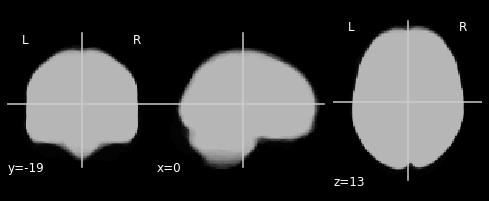

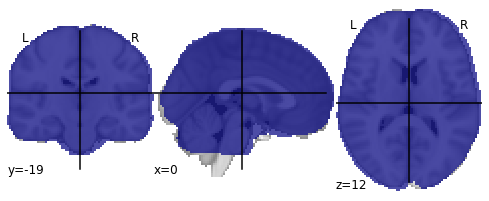

In [17]:
# run the functions - Ketamine
import nilearn
mask_img_temp = '/media/Data/KPE_BIDS/derivatives/fmriprep/sub-*/ses-[1,2]/func/sub-*_ses-[1,2]_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
mask_files = glob.glob(mask_img_temp)
mean_mask = nilearn.image.mean_img(mask_files, n_jobs=3)
plotting.plot_anat(mean_mask)

group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)


In [24]:
rightHippo_ses2_1, tTestcor , _= createDelta(ket_func_ses1, ket_func_ses2, group_mask)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]    0.0s, 0.0min: Loading resample_img...
[Memory]    0.0s, 0.0min: Loading filter_and_mask...
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]    0.1s, 0.0min: Loading resample_img...
[Memory]    0.1s, 0.0min: Loading filter_and_mask...
[NiftiMasker.fit] Loading data from [/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-008_ses-1_z.nii.gz, /home/or/kpe_conn/trauma_seed_hippocampus_right_sub-1223_ses-1_z.nii.gz, /home/or/kpe_conn/trauma_seed_hippocampus_right_sub-12
[NiftiMasker.fit] Computing the mask
[Memory]    0.0s, 0.0min: Loading compute_background_mask...
[NiftiMasker.fit] Resampling mask
[Memory]    0.0s, 0.0min: Loading resample_img...
Shape is: (11, 228337)
Sum of p values < 0.005 is 1207


In [25]:
rightHippo_mean_zcor_img, rightHippo_mean_zcor_Delta = createZimg(rightHippo_ses2_1, 'trauma', 'rightHippo', _)

    
corr_mat_thrFDR_leftAmg = fdrThr(tTestcor, rightHippo_mean_zcor_Delta, 0.05)

________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.013735, ..., 0.004351]), <nibabel.nifti1.Nifti1Image object at 0x7fcfd70ecad0>)


TypeError: X must be of shape (samples, 263864).

In [ ]:
fdr_img = brain_masker.inverse_transform(corr_mat_thrFDR_leftAmg)
%matplotlib inline
display = plotting.plot_stat_map(fdr_img,
                                     vmax=1,
                                     threshold = 0.1,
                                     cut_coords=[-40,-28,4,10],
                                      display_mode = 'y',
                                     )
display.add_markers(marker_coords=amygdala_coords, marker_color='g',
                    marker_size=100)

In [ ]:
plotting.find_xyz_cut_coords(fdr_img, mask_img=None, activation_threshold=None)

In [ ]:
plotting.find_cut_slices(fdr_img, direction='z', n_cuts=3, spacing='auto')

In [ ]:
# surface plotting
from nilearn import plotting, datasets    
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


view = plotting.view_img_on_surf(rightHippo_mean_zcor_img,surf_mesh='fsaverage5',threshold='99.5%')   

view

In [ ]:
# now lets do right Hippo
ket_func_ses1 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-1_z.nii.gz' % (sub) for sub in ketList]
ket_func_ses2 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-2_z.nii.gz' % (sub) for sub in ketList]
mid_func_ses1 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-1_z.nii.gz' % (sub) for sub in midList]
mid_func_ses2 = ['/home/or/kpe_conn/trauma_seed_hippocampus_right_sub-%s_ses-2_z.nii.gz' % (sub) for sub in midList]

In [ ]:
# run the functions - Ketamine
mask_img = '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
leftAmg_ses2_1, tTestcor , _= createDelta(ket_func_ses1, ket_func_ses2, mask_img)

In [ ]:
LeftAmg_mean_zcor_img, leftAmg_mean_zcor_Delta = createZimg(leftAmg_ses2_1, 'trauma', 'leftAmg')

    
corr_mat_thrFDR_leftAmg = fdrThr(tTestcor, leftAmg_mean_zcor_Delta, 0.05)